# Описание проекта

Задача «Классификация опор контактной сети и других
объектов в массиве точек лазерных отражений для
обеспечения безопасности движения железнодорожного
транспорта»

Российский железнодорожный комплекс — один из крупнейших в
мире. Общая протяженность эксплуатационной длины железнодорожных
путей превышает 120 тысяч километров. В прошлом году в нашей стране
поезда и электрички перевезли более 1 миллиарда пассажиров. Именно
поэтому к проектированию и эксплуатации железнодорожной
инфраструктуры предъявляются высокие требования по обеспечению
безопасности.
В связи с совершенствованием технологий геодезической съемки,
инновационным решением при диагностике, строительстве и эксплуатации
железнодорожных путей и придорожной инфраструктуры является
построение цифровых моделей пути (ЦМП) на основе данных лазерного
сканирования. Результат лазерного сканирования — это высокоточный
массив точек лазерных отражений (ТЛО), на основе которого проводятся
все необходимые измерения и последующий анализ данных. Определение
опор контактной сети (ОКС) в массиве ТЛО — это одна из обязательных
подзадач процесса определения габаритов приближения подвижного
состава к ОКС.
В настоящий момент определение взаимного расположения объектов
железнодорожной инфраструктуры происходит при натурном
обследовании — в связи с чем высок риск получения недостоверной
информации, что критично для обеспечения безопасности движения.

Участникам чемпионата предстоит создать свое решение по
прогнозированию класса ТЛО с использованием параметра этой точки.

Описание входных значений
train.csv — файл, содержащий данные для тренировки. Структура датасета:
● Параметр «id» — уникальный идентификатор ТЛО.
● Параметр «Easting» — направление на восток, условная координата Х
ТЛО в метрах
● Параметр «Northing» — направление на север, условная координата У
ТЛО в метрах
● Параметр «Height» — отметка (высота), условная координата Н ТЛО в
метрах
● Параметр «Reflectance» — отражательная способность ТЛО
● Параметр «Class» — признак класса точки
test.csv - содержит данные ТЛО для предсказания

Пояснение к данным
Столбец «Class» хранит в себе тип класса точки, где:
0 – точки земли
1 – точки опор
3 – точки растительности
4 – точки рельсов
5 – точки элементов контактной сети
64 – точки шумов
Метрика
В качестве метрики выступает Recall по столбцу Class.

In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#import catboost
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.metrics import accuracy_score, recall_score

import warnings
warnings.filterwarnings("ignore")

from tqdm import notebook

from sklearn.preprocessing import StandardScaler


import optuna
from optuna.samplers import TPESampler, GridSampler, NSGAIISampler

#from optuna.visualization import plot_optimization_history
#from optuna.visualization import plot_param_importances


import warnings
warnings.filterwarnings("ignore")

from sklearn.utils import shuffle

from tensorflow import keras
from tensorflow.keras.optimizers import Adam

In [ ]:
# Поспестим датафреймы в переменные
train = pd.read_csv('/content/drive/MyDrive/dataset/train_dataset_train.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/test_dataset_test.csv')

In [ ]:
# Выведем первые 5 строк датафрейма
train.head()

,id,Easting,Northing,Height,Reflectance,Class
0,2321251,431696.5375,6.032319e+06,69.2226,-11.14,0
1,3515173,431710.3835,6.032291e+06,68.9711,-15.16,3
2,2320295,431696.8099,6.032322e+06,69.2453,-13.59,0
3,2454459,431680.4542,6.032343e+06,69.1892,-11.21,0
4,4608150,431720.0914,6.032288e+06,67.3252,-9.10,0


In [ ]:
# Посмотрим на распрееделение целевого признака
train['Class'].value_counts()

0     2731040
3     1287816
4      103453
5       55985
1       39384
64       4416
Name: Class, dtype: int64

Text(0.5, 1.0, 'Распределение класса точки')

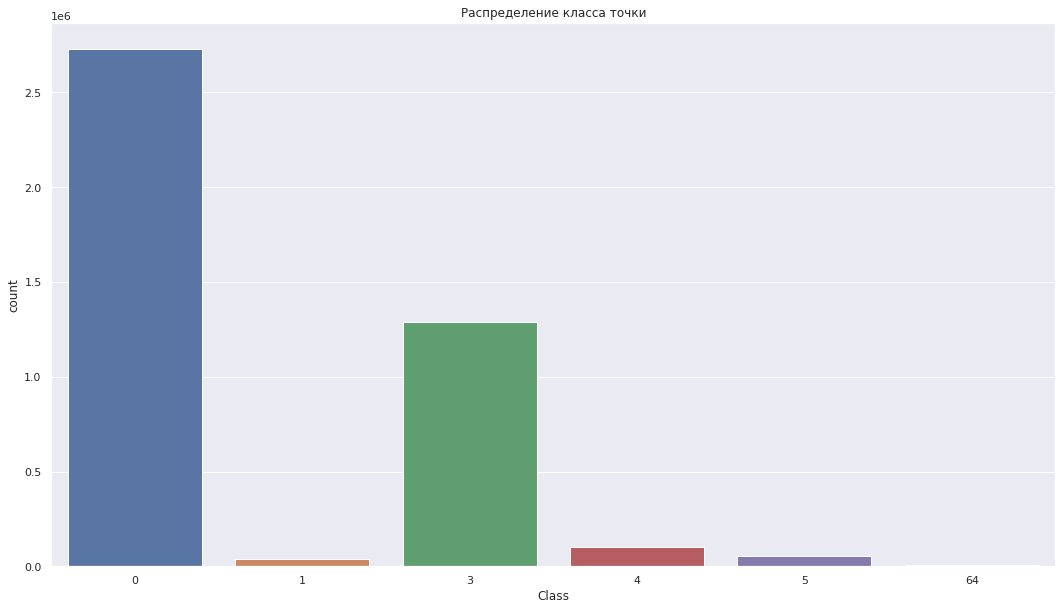

In [ ]:
sns.countplot(x = "Class" , data  = train).set_title('Распределение класса точки')

На лицо "жесткий" дисбаланс классов. Это обязательно необходимо учесть.

In [ ]:
# Посмотрим общую инфоромацию по датафрейму
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4222094 entries, 0 to 4222093
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   Easting      float64
 2   Northing     float64
 3   Height       float64
 4   Reflectance  float64
 5   Class        int64  
dtypes: float64(4), int64(2)
memory usage: 193.3 MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1809469 entries, 0 to 1809468
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   Easting      float64
 2   Northing     float64
 3   Height       float64
 4   Reflectance  float64
dtypes: float64(4), int64(1)
memory usage: 69.0 MB


In [ ]:
# Напишем функцию которая будет выводит долю пропусков с сортировкой по убыванию

def data_omissions(data):
    return pd.DataFrame(
        data
        .isna()
        .mean()
        .round(4)*100).sort_values(by=0)[::-1].style.background_gradient('coolwarm')

In [ ]:
# Проверим наличи е пропусков в датафреймах
data_omissions(train)

,0
Class,0.000000
Reflectance,0.000000
Height,0.000000
Northing,0.000000
Easting,0.000000
id,0.000000


In [ ]:
data_omissions(test)

,0
Reflectance,0.000000
Height,0.000000
Northing,0.000000
Easting,0.000000
id,0.000000


Пропуски в наборах данных отсуствуют.

In [ ]:
# Проверим наличие явнях дубликатов
train.duplicated().sum()

0

In [ ]:
test.duplicated().sum()

0

Явные дубликаты в датафреймах также отсуствуют.

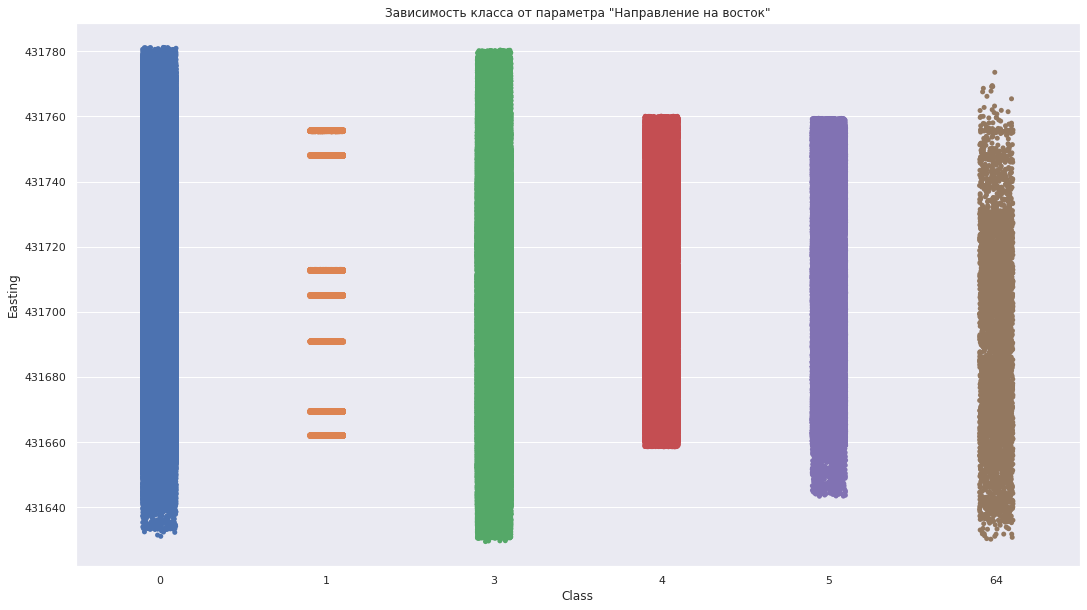

In [ ]:
# Посморим на зависимость классов целевого признака
sns.set(rc={'figure.figsize':(18,10)})
sns.stripplot(data = train, x= "Class", y = "Easting").set_title('Зависимость класса от параметра "Направление на восток"');

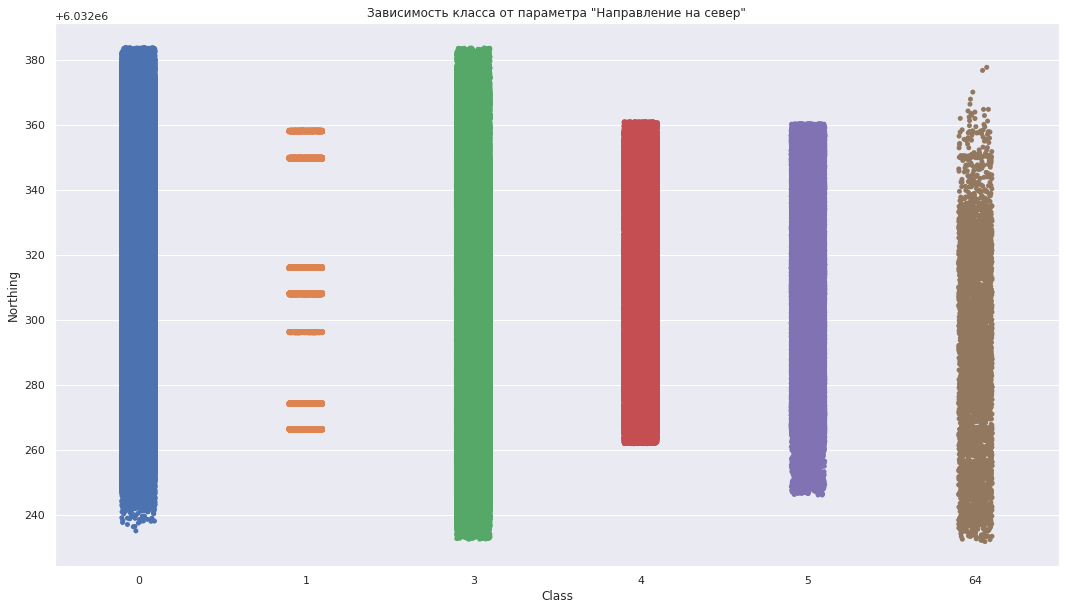

In [ ]:
sns.set(rc={'figure.figsize':(18,10)})
sns.stripplot(data = train, x= "Class", y = "Northing").set_title('Зависимость класса от параметра "Направление на север"');

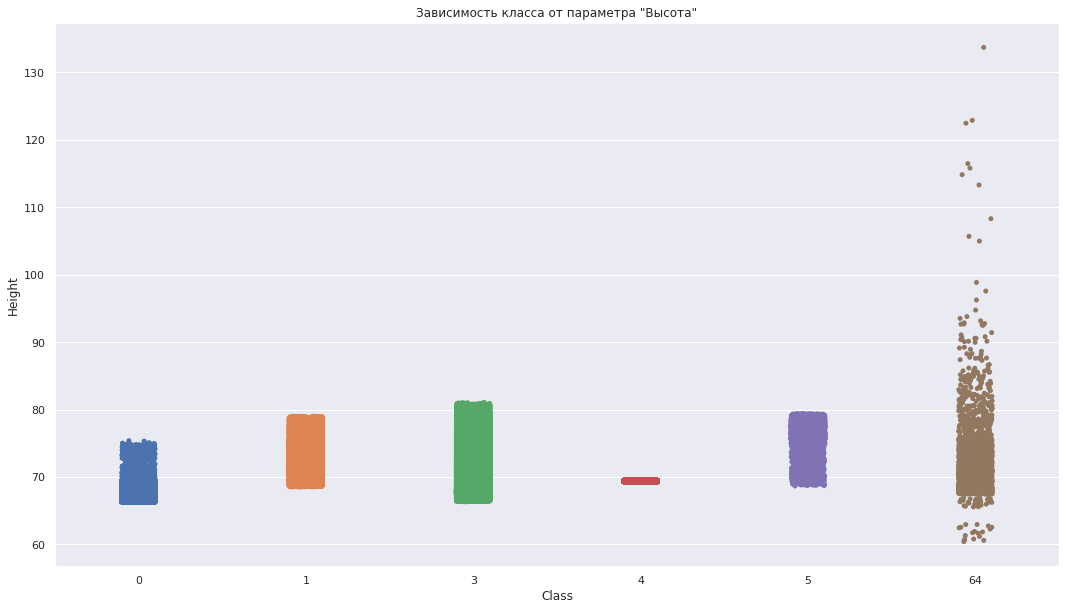

In [ ]:
sns.set(rc={'figure.figsize':(18,10)})
sns.stripplot(data = train, x= "Class", y = "Height").set_title('Зависимость класса от параметра "Высота"');

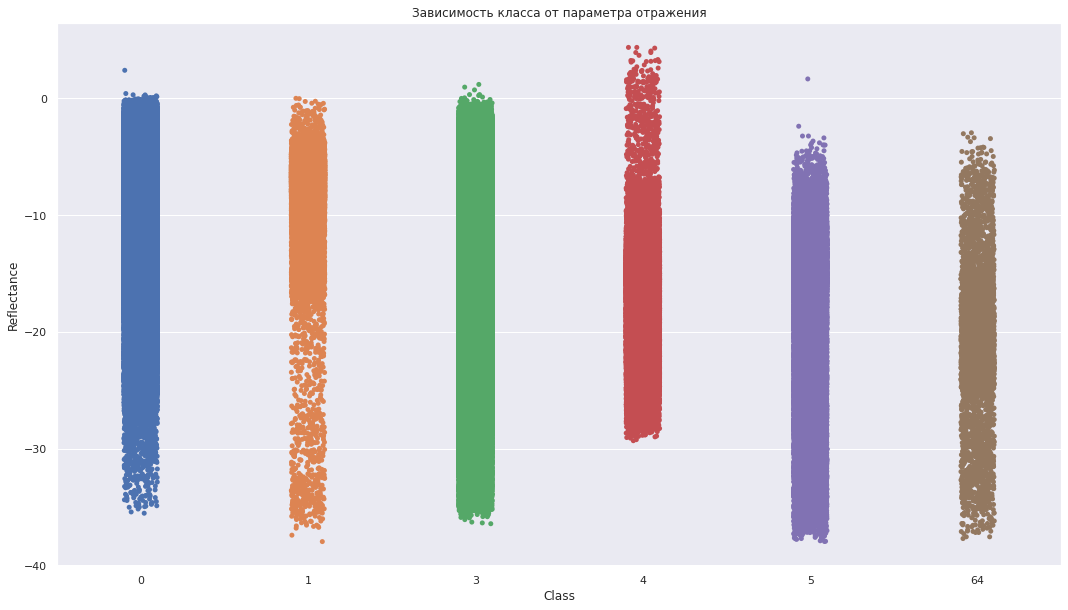

In [ ]:
sns.set(rc={'figure.figsize':(18,10)})
sns.stripplot(data = train, x= "Class", y = "Reflectance").set_title('Зависимость класса от параметра отражения');

Полученные графики выглядят вполне правдоподобно. 

In [ ]:
#train.drop('Reflectance', axis=1, inplace=True)
#test.drop('Reflectance', axis=1, inplace=True)

In [ ]:
# Обозначим индексами 'id'
train.set_index('id', inplace=True)
test.set_index('id', inplace=True)

In [ ]:
# Сформируем переменные с призанками для обучения и целевым признаком
features = train.drop('Class', axis=1)
target = train['Class']

In [ ]:
# Посмотрим на первые 5 строк
features.head()

,Easting,Northing,Height,Reflectance
id,,,,
2321251,431696.5375,6.032319e+06,69.2226,-11.14
3515173,431710.3835,6.032291e+06,68.9711,-15.16
2320295,431696.8099,6.032322e+06,69.2453,-13.59
2454459,431680.4542,6.032343e+06,69.1892,-11.21
4608150,431720.0914,6.032288e+06,67.3252,-9.10


In [ ]:
target.head()

id
2321251    0
3515173    3
2320295    0
2454459    0
4608150    0
Name: Class, dtype: int64

count    4222094
mean          69
std            2
min           60
25%           68
50%           69
75%           69
max          134
Name: Height, dtype: object

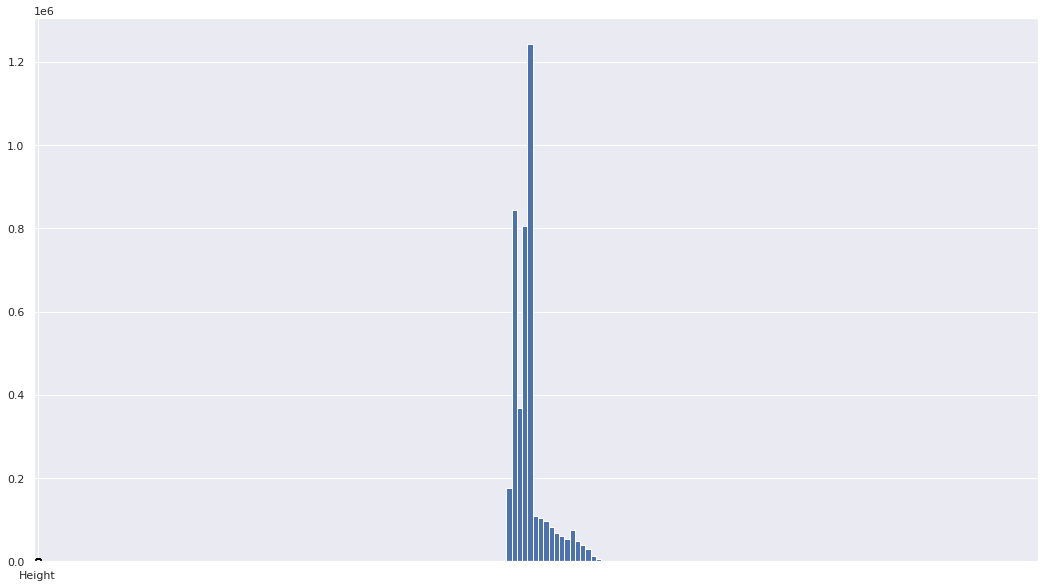

'******************************'

count    4222094
mean         -11
std            5
min          -38
25%          -13
50%          -10
75%           -8
max            4
Name: Reflectance, dtype: object

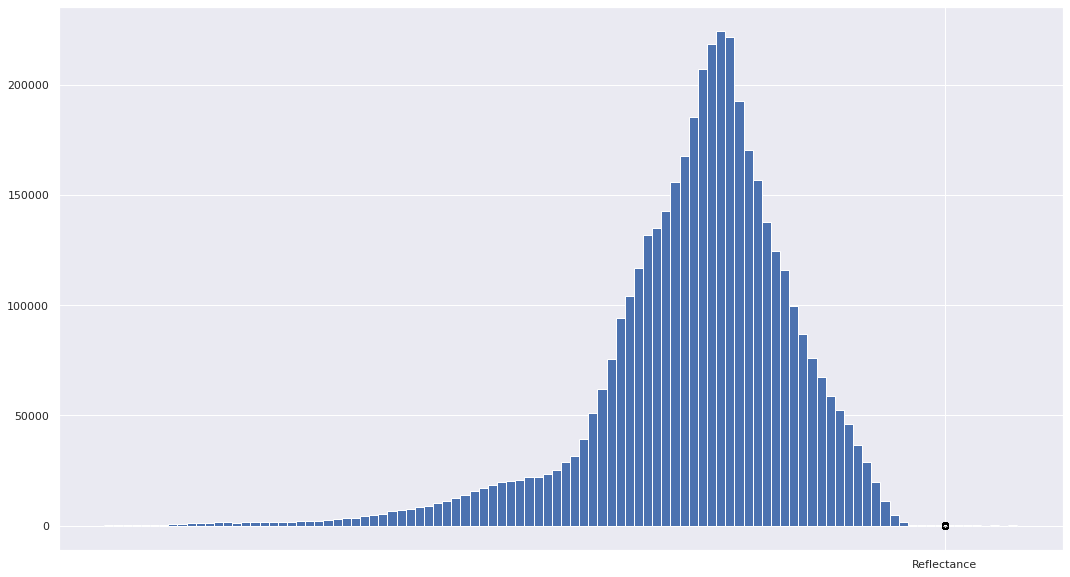

'******************************'

count    1809469
mean          69
std            2
min           61
25%           68
50%           69
75%           69
max          116
Name: Height, dtype: object

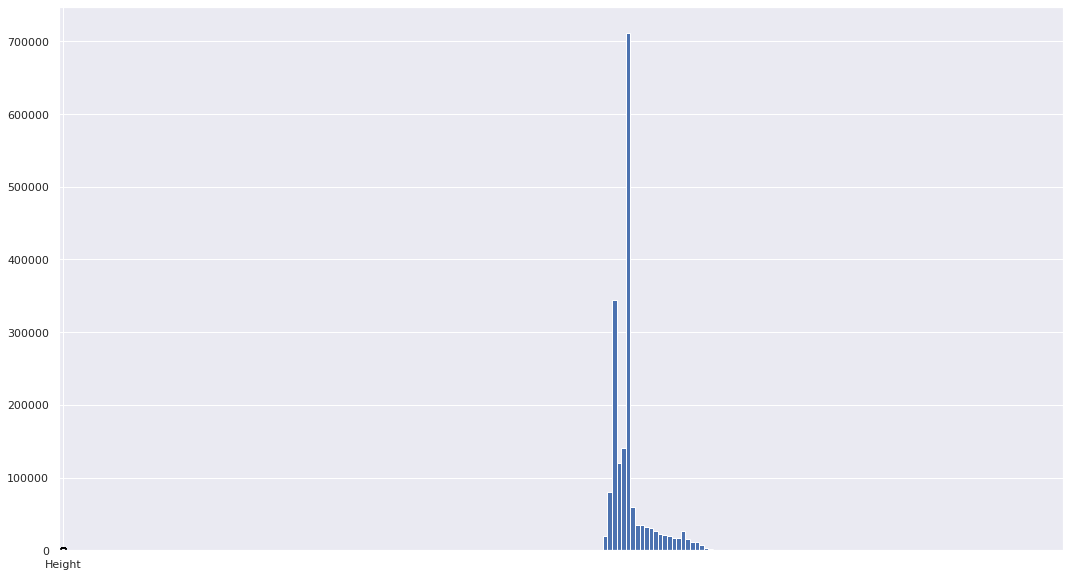

'******************************'

count    1809469
mean         -11
std            5
min          -38
25%          -13
50%          -10
75%           -8
max            3
Name: Reflectance, dtype: object

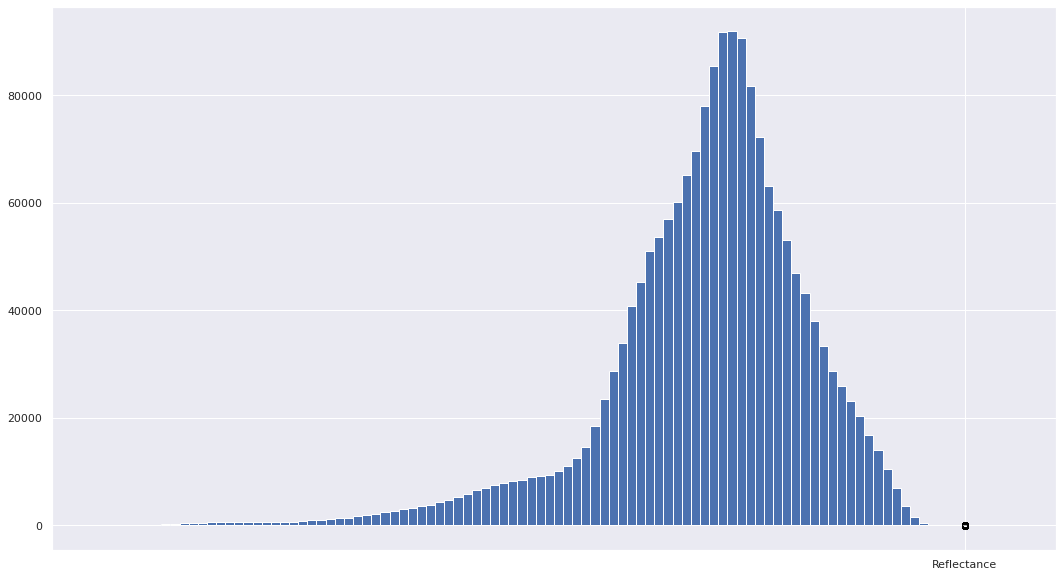

'******************************'

In [ ]:
for data in [features, test]:
  for elm in ['Height', 'Reflectance']:
    display(data[elm].describe().apply("{0:.0f}".format))
    display(data.boxplot(column=elm))
    data[elm].hist(bins=100)
    plt.show()
    display('*'*30)

In [ ]:
# Осуществим стандартизацию наборов данных
scaler = StandardScaler()
scaler.fit(features)
features = scaler.transform(features)

test = scaler.transform(test)

In [ ]:
# Сформируем датафреймы из наборов данных после проведённой стандартизации
features = pd.DataFrame(features, columns=train.drop('Class', axis=1).columns)
test = pd.DataFrame(test, columns=train.drop('Class', axis=1).columns)

In [ ]:
# Выведем первые 5 строк
features.head()

,Easting,Northing,Height,Reflectance
0,-0.343775,0.393636,-0.078855,-0.134956
1,0.121280,-0.573362,-0.189654,-1.025267
2,-0.334626,0.493958,-0.068855,-0.677559
3,-0.883976,1.170407,-0.093570,-0.150459
4,0.447347,-0.663300,-0.914757,0.316843


In [ ]:
# Посмотрим на наличие взаимосвяей в наборе данных
features.corr()

,Easting,Northing,Height,Reflectance
Easting,1.000000,-0.731936,-0.201393,0.055291
Northing,-0.731936,1.000000,-0.256841,0.143781
Height,-0.201393,-0.256841,1.000000,-0.285061
Reflectance,0.055291,0.143781,-0.285061,1.000000


In [ ]:
test.corr()

,Easting,Northing,Height,Reflectance
Easting,1.000000,-0.732367,-0.201187,0.055186
Northing,-0.732367,1.000000,-0.256660,0.144551
Height,-0.201187,-0.256660,1.000000,-0.285435
Reflectance,0.055186,0.144551,-0.285435,1.000000


In [ ]:
# В наборе признаков 'features' возьмём за индексы значения 'id' из 'train'
features['id'] = train.index
features.set_index('id', inplace=True)

In [ ]:
# Выведем первые 5 строк
features.head()

,Easting,Northing,Height,Reflectance
id,,,,
2321251,-0.343775,0.393636,-0.078855,-0.134956
3515173,0.121280,-0.573362,-0.189654,-1.025267
2320295,-0.334626,0.493958,-0.068855,-0.677559
2454459,-0.883976,1.170407,-0.093570,-0.150459
4608150,0.447347,-0.663300,-0.914757,0.316843


In [ ]:
target.head()

id
2321251    0
3515173    3
2320295    0
2454459    0
4608150    0
Name: Class, dtype: int64

In [ ]:
# Разобьём наборы данных  с целью выделения тестовой выборки
features, X_test, target, y_test = train_test_split(features, target, test_size=0.2, random_state=1234)

# CatBoost + Optuna (X_val)

In [ ]:
# Напишем функцию для подбора оптимальных гиперпараметров на основе подборщика гиперпараметров optuna
def objective(trial, X_train=features, y_train=target):
    # Зададим сетку параметров    
    params = {
        'iterations': trial.suggest_int('iterations', 100, 2500),
        #'max_depth': trial.suggest_int('max_depth', 2, 16),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.001, 0.002, 0.003, 0.004, 0.005, 0.007, 0.009, 
                                                                     0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 
                                                                     0.1, 0.2, 
                                                                     0.221, 0.2211, 0.2212, 0.2213, 0.2214, 0.2215, 0.2216, 0.2217, 0.2218, 0.2219,  
                                                                     0.222, 0.2221, 0.2222, 0.2223, 0.2224, 0.2225, 0.2226, 0.2227, 0.2228, 0.2229, 
                                                                     0.223, 0.2231, 0.2232, 0.2233, 0.2234, 0.2235, 0.2236, 0.2237, 0.2238, 0.2239, 
                                                                     0.224, 0.2241, 0.2242, 0.2243, 0.2244, 0.2245, 0.2246, 0.2247, 0.2248, 0.2249, 
                                                                     0.225, 0.2251, 0.2252, 0.2253, 0.2254, 0.2255, 0.2256, 0.2257, 0.2258, 0.2259, 
                                                                     0.226, 0.227, 0.228, 0.229, 0.23, 0.24, 0.25, 0.275, 
                                                                     0.3, 0.4, 0.5, 0.7, 0.8]),
        #'n_estimators': trial.suggest_int('n_estimators', 100, 4000),
        #'max_bin': trial.suggest_int('max_bin', 2, 30),
        #'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
        #'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0001, 5.0, log = True),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 2, 30),
        #'subsample': trial.suggest_float('subsample', 0.1, 0.8),
        'random_seed': 12345,
        'loss_function':  trial.suggest_categorical('loss_function', ['MultiClass', 'MultiClassOneVsAll']),
        'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['Balanced', 
                                                                               #'SqrtBalanced'
                                                                               ]),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS'])
        }

    if params['bootstrap_type'] == 'Bayesian':
      params['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 10)
    elif params['bootstrap_type'] == 'Bernoulli':
      params['subsample'] = trial.suggest_float('subsample', 0.1, 1)

    # Объявим переменную в которой будет храниться пустой список
    score_list = []

    # Сформирум генератор случайных чисел
    state = np.random.RandomState(12345)

    # Обучение будем проводить на случайной выборке, которое повторится 3 раза (на полном объёме данных провести обучение в colab не получится)
    for _ in range(2):
      # сформируем случайную выборку признаков для обучения модели
      signs_features = features.sample(n=300000, 
                                       replace=True, 
                                       random_state=state
                                       )
      # Разобъём наборы данных на выборки обучающую и валидационную
      X_train, X_val, y_train, y_val = train_test_split(signs_features, target.loc[signs_features.index], test_size=0.25, random_state=1234)

      # Объявляем модель
      model = CatBoostClassifier(**params, verbose = False)
      # Обучаем модель
      model.fit(X_train, y_train, eval_set = [(X_val, y_val)], early_stopping_rounds = 70)  
      # Формирум предсказания на валидационной выборке
      pred_val = model.predict(X_val)
      # Делаем расчёт recal и записывем полученного значения в список
      score_list.append(recall_score(y_val, pred_val, average='macro'))
    return sum(score_list)/len(score_list)

In [ ]:
# Создадим объект study
study = optuna.create_study(direction = 'maximize', 
                            #sampler=TPESampler(),
                            sampler=NSGAIISampler(),
                           )
# Запустим исследование
study.optimize(objective, n_trials = 30)

display(f'Best value: {study.best_value}')
display(f'Best_params: {study.best_params}')

[I 2022-10-14 05:11:56,350] A new study created in memory with name: no-name-5050409a-be98-4c12-8ea4-49e8259e27d8
[I 2022-10-14 05:13:14,257] Trial 0 finished with value: 0.8992966206926878 and parameters: {'iterations': 504, 'learning_rate': 0.225, 'l2_leaf_reg': 27, 'loss_function': 'MultiClass', 'auto_class_weights': 'Balanced', 'bootstrap_type': 'Bernoulli', 'subsample': 0.11466610324492348}. Best is trial 0 with value: 0.8992966206926878.
[I 2022-10-14 05:20:37,936] Trial 1 finished with value: 0.8120373800535585 and parameters: {'iterations': 1224, 'learning_rate': 0.002, 'l2_leaf_reg': 9, 'loss_function': 'MultiClassOneVsAll', 'auto_class_weights': 'Balanced', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.685169574116564}. Best is trial 0 with value: 0.8992966206926878.
[I 2022-10-14 05:21:25,650] Trial 2 finished with value: 0.9031265972946885 and parameters: {'iterations': 169, 'learning_rate': 0.2245, 'l2_leaf_reg': 4, 'loss_function': 'MultiClass', 'auto_class_weigh

'Best value: 0.9183408439540922'

"Best_params: {'iterations': 1358, 'learning_rate': 0.2243, 'l2_leaf_reg': 17, 'loss_function': 'MultiClassOneVsAll', 'auto_class_weights': 'Balanced', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8865681558889895}"

In [ ]:
# Вывим исторю обучения
optuna.visualization.plot_optimization_history(study)

In [ ]:
# Осуществим обучение моделей на гиперпараметрах моделей с лучшими оценками (больше 0.916)
# сформирум словарь с recal полученным на этапе подбора гиперпараметров, на обучающей выборке, на валидациооной и тестовой 
signs_features = features.sample(n=1000000, 
                                 replace=True, 
                                 random_state=1234
                                 )
features_train, X_val, target_train, y_val = train_test_split(signs_features, target.loc[signs_features.index], test_size=0.25, random_state=1234)
reslt = {}
for i in notebook.tqdm(range(len(study.get_trials()))):
    if study.get_trials()[i].value > 0.91:
        model = CatBoostClassifier(**study.get_trials()[i].params, random_state=12345)  
        model.fit(features_train, target_train, verbose = False)

        pred_features = model.predict(features_train)
        recall_metric_features_train = recall_score(pred_features, target_train, average='macro')

        pred_val = model.predict(X_val)
        recall_metric_val = recall_score(pred_val, y_val, average='macro')

        pred_test = model.predict(X_test)
        recall_metric_test = recall_score(pred_test, y_test, average='macro')
     
        reslt[i] = [recall_metric_features_train, recall_metric_val, recall_metric_test]

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
reslt

{3: [0.7845651706704655, 0.7752102036076175, 0.776177139671582],
 4: [0.7594876117910904, 0.7538789478884299, 0.7550779866464047],
 6: [0.8182355156894151, 0.801579034782507, 0.8013515866463857],
 7: [0.8021461545248418, 0.7890518313432233, 0.7889557724660746],
 8: [0.7963303527827903, 0.7860814108907493, 0.785519215188068],
 9: [0.796521815590144, 0.785359415878589, 0.7853450519189059],
 12: [0.7841034685804787, 0.7749201413746284, 0.7756504387506894],
 13: [0.7690801452330996, 0.7620120417366932, 0.7632820357898956],
 14: [0.7907386619599684, 0.7801581947922953, 0.780280057608458],
 16: [0.7864912378292236, 0.775833491019062, 0.7768898718253312],
 18: [0.7954594105589318, 0.7841715146947524, 0.7847528582577734],
 24: [0.8094859757967208, 0.7960233768124901, 0.7949718559612226],
 25: [0.7727352530833124, 0.766382843361745, 0.7671211959013374],
 29: [0.7963934996414311, 0.7851333083703008, 0.7848356400367661]}

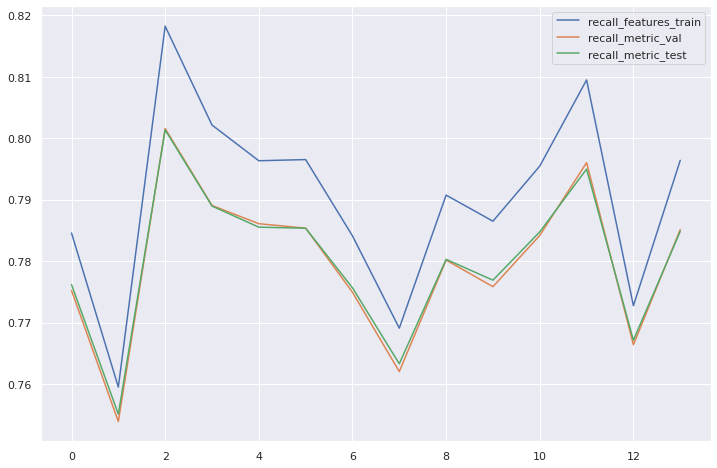

In [ ]:
df_result = pd.DataFrame(list(reslt.values()), columns=['recall_features_train', 'recall_metric_val', 'recall_metric_test'])
df_result.plot(figsize=(12, 8))

In [ ]:

model = CatBoostClassifier(**study.get_trials()[6].params, random_state=12345)
model.fit(features, target, verbose = False)

pred_test = model.predict(X_test)
recall_metric_test = recall_score(y_test, pred_test, average='macro')

accuracy_metric = accuracy_score(y_test, pred_test)

display(f'accuracy_metric: {accuracy_metric}')
display(f'recall_metric: {recall_metric_test}')

'accuracy_metric: 0.957245159097557'

'recall_metric: 0.967111688781393'

Score = 0.963340

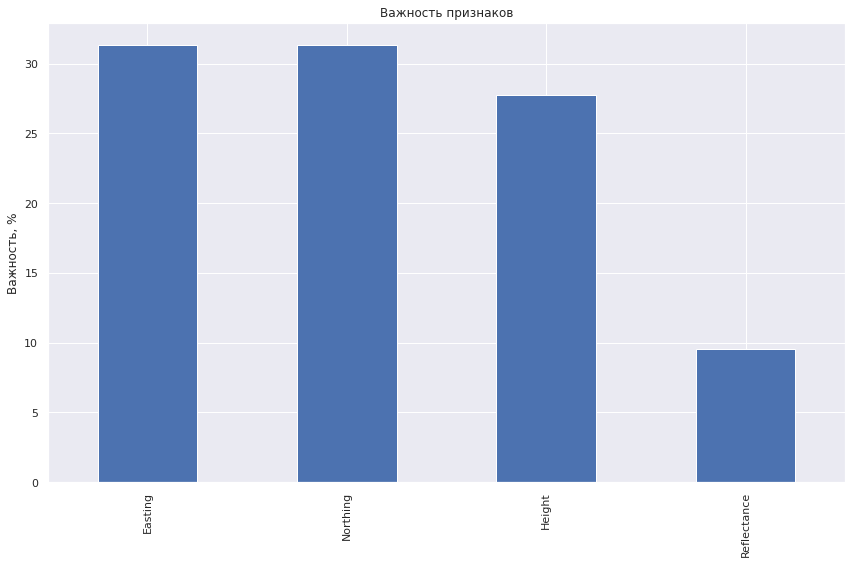

In [ ]:
# Построим гистограмму для визуализации важности признаков
cat_train_imp = pd.Series(model.get_feature_importance(), features.columns)

fig, ax = plt.subplots(figsize=(12,8))
cat_train_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

In [ ]:
pr = model.predict(test)
pr = pr.tolist()
list_pred = []
for i in pr:
  list_pred.append(i[0])

test = pd.read_csv('/content/drive/MyDrive/dataset/test_dataset_test.csv')

df = pd.DataFrame({
    'id': test['id'], 
    'Class': list_pred
})



In [ ]:
df['Class'].value_counts()

0     1135465
3      558699
4       62766
5       23916
1       17277
64      11346
Name: Class, dtype: int64

In [ ]:
df.to_csv('predicted_27.csv', index=False)

In [ ]:
#Score = 0.754982
#recall_metric: 0.7526915032728834
#Best value: 0.841522637514464
#Best_params: {'max_depth': 9, 'learning_rate': 0.5, 'n_estimators': 38, 'max_bin': 24, 'min_data_in_leaf': 200, 'l2_leaf_reg': 0.0008011633642387359, 'loss_function': 'MultiClass'}
#100000

In [ ]:
#Score = 0.807797
#recall_metric: 0.8014370723619487
#Best value: 0.8291876535637936
#Best_params: {'max_depth': 13, 'learning_rate': 0.5, 'n_estimators': 66, 'max_bin': 22, 'min_data_in_leaf': 180, 'l2_leaf_reg': 0.10986580533658863, 'loss_function': 'MultiClassOneVsAll'}
#300000

In [ ]:
#Score = 0.900207
#recall_metric: 0.8999397568494437
#Best value: 0.8654414903722994
#Best_params: {'max_depth': 9, 'learning_rate': 0.3, 'n_estimators': 44, 'max_bin': 18, 'min_data_in_leaf': 231, 'l2_leaf_reg': 0.03190158927441474, 'loss_function': 'MultiClassOneVsAll', 'auto_class_weights': 'Balanced'}
#300000 70

In [ ]:
#Score = 0.906125
#recall_metric: 0.9084255978670154
#Best value: 0.8592832852709422
#Best_params: {'max_depth': 9, 'learning_rate': 0.5, 'n_estimators': 34, 'max_bin': 18, 'min_data_in_leaf': 8, 'l2_leaf_reg': 0.4552604795057078, 'loss_function': 'MultiClass', 'auto_class_weights': 'Balanced'}
#300000 90

In [ ]:
#Score = 0.910499
#recall_metric: 0.9109054592760254
#Best value: 0.8706784317103701
#Best_params: {'max_depth': 12, 'learning_rate': 0.1, 'n_estimators': 91, 'max_bin': 30, 'min_data_in_leaf': 29, 'l2_leaf_reg': 0.06717381330553611, 'loss_function': 'MultiClassOneVsAll', 'auto_class_weights': 'Balanced'}
#300000 (30,91)

In [ ]:
#Score = 0.924016
#recall_metric: 0.9227591218571063
#Best value: 0.8791603607620682
#Best_params: {'max_depth': 12, 'learning_rate': 0.5, 'n_estimators': 123, 'max_bin': 25, 'min_data_in_leaf': 76, 'l2_leaf_reg': 0.3388793028599401, 'loss_function': 'MultiClassOneVsAll', 'auto_class_weights': 'Balanced'}
#300000 (90,150)


In [ ]:
#Score = 0.930843
#recall_metric: 0.9331572085823786
# практически на дефолтных настройках loss_function='MultiClassOneVsAll'

In [ ]:
#Score = 0.956095
#recall_metric: 0.9585310905875182
# практически на дефолтных настройках loss_function='MultiClass'


In [ ]:
#Score = 0.166667
#recall_metric: 0.9616341568664165
#Best value: 0.906315908645418
#Best_params: {'learning_rate': 0.2, 'loss_function': 'MultiClass', 'auto_class_weights': 'Balanced'}

In [ ]:
#Score = 0.960277
#recall_metric: 0.9628062125373701
#0.9114694615611281
#parameters: {'learning_rate': 0.2, 'loss_function': 'MultiClassOneVsAll', 'auto_class_weights': 'Balanced', 'bootstrap_type': 'Bernoulli'}

In [ ]:
#Score = 0.963365
#recall_metric: 0.9644
#Best value: 0.907956379006141
#Best_params: {'iterations': 1525, 'learning_rate': 0.2, 'loss_function': 'MultiClassOneVsAll', 'auto_class_weights': 'Balanced', 'bootstrap_type': 'MVS'}
#

In [ ]:
#Score = 0.963444
#recall_metric: 0.9657428250574149
#value: 0.9098061880671
#parameters: {'iterations': 1257, 'learning_rate': 0.45, 'loss_function': 'MultiClassOneVsAll', 'auto_class_weights': 'Balanced', 'bootstrap_type': 'MVS'}

In [ ]:
#Score = 0.964918
#recall_metric: 0.9658850806514572
#Best value: 0.875467117675569
#Best_params: {'iterations': 1897, 'learning_rate': 0.225, 'loss_function': 'MultiClassOneVsAll', 'auto_class_weights': 'Balanced', 'bootstrap_type': 'MVS'}
#

In [ ]:
#Score = 0.964743
#recall_metric: 0.9668161945179691
#Best value: 0.9214652667863584
#Best_params: {'iterations': 2133, 'learning_rate': 0.222, 'l2_leaf_reg': 24, 'loss_function': 'MultiClassOneVsAll', 'auto_class_weights': 'Balanced', 'bootstrap_type': 'MVS'}
#

In [ ]:
#Score = 0.965092
#recall_metric: 0.96663788100301
#value: 0.0.9241117079853284
#params: {'iterations': 2448, 'learning_rate': 0.2237, 'l2_leaf_reg': 33, 'loss_function': 'MultiClassOneVsAll', 'auto_class_weights': 'Balanced', 'bootstrap_type': 'MVS'}

In [ ]:
#Score = 0.963741
#recall_metric: 0.96595913038582
#value: 0.9209599036784443
#params: {'iterations': 1286, 'learning_rate': 0.4, 'l2_leaf_reg': 45, 'loss_function': 'MultiClass', 'auto_class_weights': 'Balanced', 'bootstrap_type': 'MVS'}

In [ ]:
#Score = 0.963340
#recall_metric: 0.967111688781393
#value: 0.9138826252353281
#parameters: {'iterations': 2078, 'learning_rate': 0.2222, 'l2_leaf_reg': 10, 'loss_function': 'MultiClass', 'auto_class_weights': 'Balanced', 'bootstrap_type': 'MVS'}

In [ ]:
test = test.merge(df, on='id', how='outer')

In [ ]:
test.shape

(1809469, 6)

In [ ]:
test.head()

,id,Easting,Northing,Height,Reflectance,Class
0,1836965,431754.6192,6.032265e+06,69.2608,-13.99,0
1,3659389,431654.4141,6.032344e+06,68.0129,-10.99,3
2,5433033,431686.8574,6.032334e+06,69.2442,-10.26,0
3,1168709,431711.5747,6.032293e+06,69.6617,-8.25,3
4,5821779,431728.5806,6.032315e+06,67.6753,-7.56,3


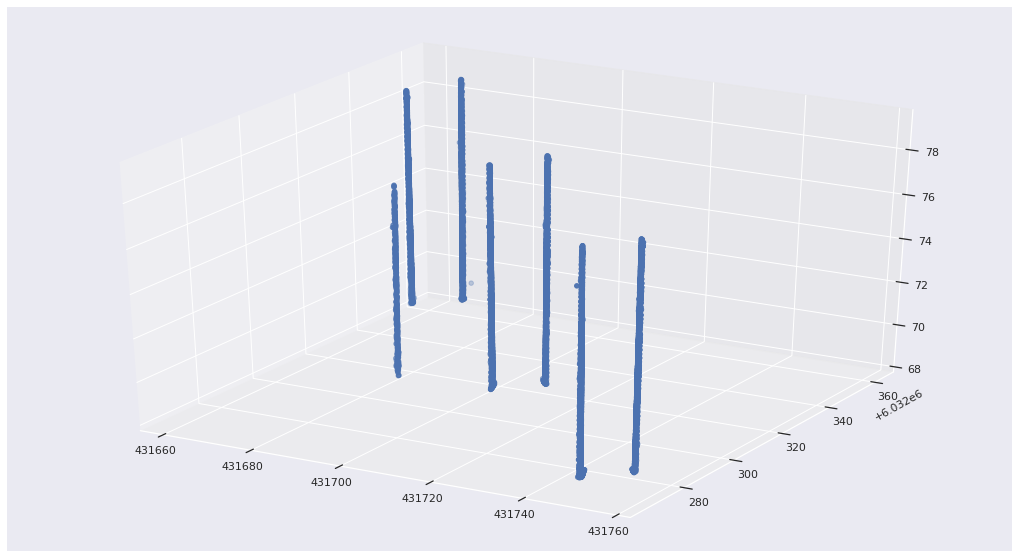

In [ ]:
# Посмотрим на точки опор контактной сети
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(test.query('Class == 1')['Easting'], test.query('Class == 1')['Northing'], test.query('Class == 1')['Height'])

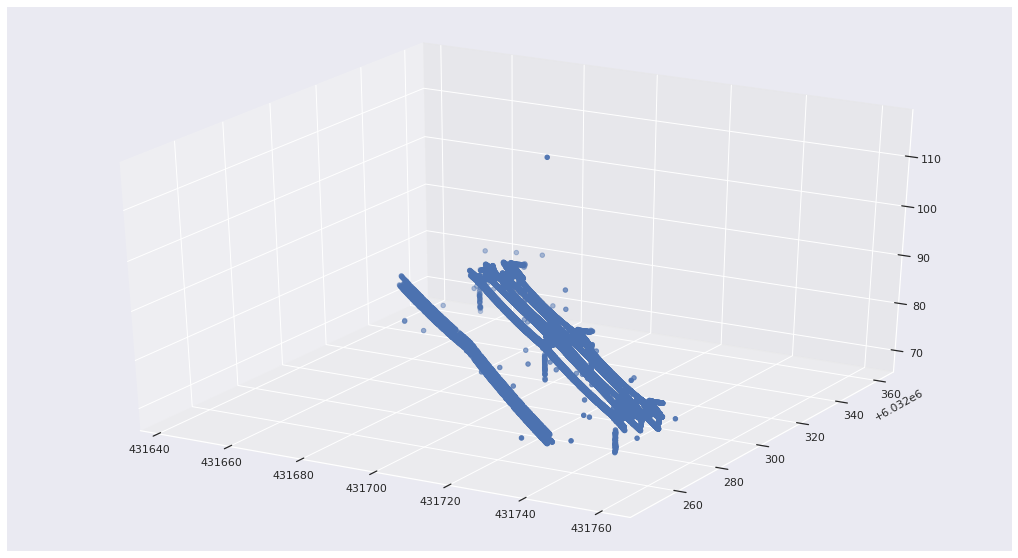

In [ ]:
# Посмотрим на точки элементов контактной сети
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(test.query('Class == 5')['Easting'], test.query('Class == 5')['Northing'], test.query('Class == 5')['Height'])


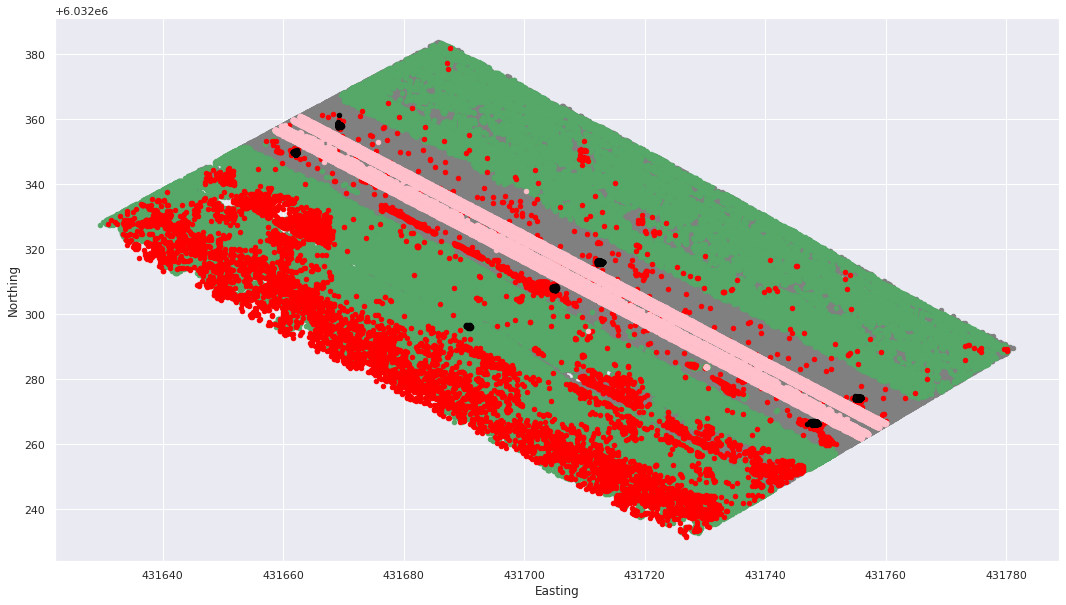

In [ ]:
# Посмотрим на точки земли, растительности, рельсов и шумов
ax = test.query('Class == 0').plot(x='Easting', y='Northing', kind='scatter', color = 'grey')
ax = test.query('Class == 3').plot(x='Easting', y='Northing', kind='scatter', color = 'g', ax=ax)
ax = test.query('Class == 64').plot(x='Easting', y='Northing', kind='scatter', color = 'red', ax=ax)
ax = test.query('Class == 4').plot(x='Easting', y='Northing', kind='scatter', color='pink', ax=ax)
test.query('Class == 1').plot(x='Easting', y='Northing', kind='scatter', color='black', ax=ax)